In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
from utils import *
from behavior_utils import *
import shutil
import os

### Set up paths

In [4]:
# Build paths
root_path = 'D:/data/'
experiment = 'clickbait-motivate'
session_type = 'm'

data_dir = os.path.join(root_path, experiment)
save_dir = os.path.join(root_path, experiment, "preprocessed")
gain = 0.1949999928474426

os.makedirs(save_dir, exist_ok=True)
open_ephys_dir = os.path.join(data_dir, "open-ephys")

### Get continuous.dat file paths

In [5]:
data_paths = get_file_paths(directory=open_ephys_dir, extension='dat', keyword='continuous', print_paths=True)
sync_paths = get_file_paths(directory=open_ephys_dir, extension='txt', keyword='sync_messages', print_paths=False)

Found 76 continuous.dat files
0 D:\data\clickbait-motivate\open-ephys\m1_2025-10-08_13-18-56_7010\Record Node 113\experiment1\recording1\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
1 D:\data\clickbait-motivate\open-ephys\m1_2025-10-08_15-08-37_7012\Record Node 113\experiment1\recording1\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
2 D:\data\clickbait-motivate\open-ephys\m1_2025-10-08_15-59-59_7013\Record Node 113\experiment1\recording1\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
3 D:\data\clickbait-motivate\open-ephys\m2_2025-10-09_11-01-00_7013\Record Node 113\experiment1\recording1\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
4 D:\data\clickbait-motivate\open-ephys\m2_2025-10-09_11-58-36_7010\Record Node 113\experiment1\recording1\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
5 D:\data\clickbait-motivate\open-ephys\m2_2025-10-09_12-50-40_7011\Record Node 113\experiment1\recording

In [6]:
# Extract session and mouse ids and build a dataframe for easy mkdir later
session_ids, mouse_ids = get_ids_from_path(data_paths, part=4)
data_df = pd.DataFrame({"session_id": session_ids, "mouse_id": mouse_ids, "continuous.dat": data_paths})
data_df.head()

,session_id,mouse_id,continuous.dat
0,m1,7010,D:\data\clickbait-motivate\open-ephys\m1_2025-...
1,m1,7012,D:\data\clickbait-motivate\open-ephys\m1_2025-...
2,m1,7013,D:\data\clickbait-motivate\open-ephys\m1_2025-...
3,m2,7013,D:\data\clickbait-motivate\open-ephys\m2_2025-...
4,m2,7010,D:\data\clickbait-motivate\open-ephys\m2_2025-...


### Preprocess Open Ephys continuous.dat 

In [7]:
# trode_ch = 32  # Number of tetrode channels
# sniff_ch = -1  # Sniff ADC channel
# ttl_ch = -2  # TTL ADC channel

# for ii in range(len(data_df)):  
#     print(f"{ii} Preprocessing {data_df['mouse_id'][ii]}-{data_df['session_id'][ii]} ({ii+1}/{len(data_df)})")
    
#     # Making the data directory
#     preprocessed_dir = os.path.join(save_dir, data_df['mouse_id'][ii], data_df['session_id'][ii])
#     os.makedirs(preprocessed_dir, exist_ok=True)
    
#     # Loading the data using memory mapping 
#     data = np.memmap(data_df['continuous.dat'][ii], dtype=np.int16, mode='r')
#     data = data.reshape((-1, 40), order='C').T  # Reshape to (40, n_samples)
    
#     # ===== PROCESS EPHYS =====
#     # Extract and process ephys channels one at a time
#     ephys = np.empty((trode_ch, data.shape[1]), dtype=np.float32)  # Use float32 instead of float64
#     ephys[:] = data[:trode_ch, :] * gain
    
#     # Process ephys signal
#     sos = signal.butter(4, [300, 6000], 'bandpass', fs=30000, output='sos')
#     ephys = signal.sosfiltfilt(sos, ephys)
    
#     # Median common average referencing within each region. Ch 1-16 in CA1, Ch 17-32 in OB.
#     ephys[:trode_ch//2, :] -= np.median(ephys[:trode_ch//2, :], axis=0, keepdims=True)
#     ephys[trode_ch//2:, :] -= np.median(ephys[trode_ch//2:, :], axis=0, keepdims=True)
    
#     # Save MUA
#     ephys = ephys.astype(np.int16)
#     np.save(os.path.join(preprocessed_dir, 'mua.npy'), ephys)
#     del ephys
    
#     # ===== PROCESS SNIFF =====
#     # Extract sniff channel directly without creating intermediate arrays
#     sniff = data[sniff_ch, :].astype(np.float32)  # Use float32
    
#     b, a = signal.iirnotch(60, 10, 30_000)
#     sniff = signal.filtfilt(b, a, sniff)
#     sos = signal.butter(3, 40, 'low', fs=30_000, output='sos')
#     sniff = signal.sosfiltfilt(sos, sniff)
#     sniff -= np.median(sniff)
#     sniff = signal.decimate(sniff, 30)
    
#     # Save sniff signal
#     sniff = sniff.astype(np.int16)
#     np.save(os.path.join(preprocessed_dir, 'sniff.npy'), sniff)
#     del sniff
    
#     # ===== PROCESS TTL =====
#     ttl = data[ttl_ch, :].astype(np.float32)  # Use float32
#     ttl = signal.decimate(ttl, 30)
#     ttl_bool = ttl > 0.0
#     del ttl 
    
#     ttl_diffs = np.diff(ttl_bool.astype(np.int8))
#     ttl_times = np.where(ttl_diffs == -1)[0]
    
#     # Save TTLs
#     ttl_times = ttl_times.astype(np.int32)
#     np.save(os.path.join(preprocessed_dir, 'ttl_signal.npy'), ttl_bool)
#     np.save(os.path.join(preprocessed_dir, 'ttl_times.npy'), ttl_times)
#     del ttl_bool, ttl_diffs, ttl_times
    
#     del data  # Clean up memmap

### Updated Version (WIP)

In [8]:
trode_ch = 32  # Number of tetrode channels
sniff_ch = -1  # Sniff ADC channel
ttl_ch = -2  # TTL ADC channel
reward_state_ch = -3  # Reward state ADC channel
flip_state_ch = -4  # Flip state ADC channel

for ii in range(len(data_df)):  
    print(f"{ii} Preprocessing {data_df['mouse_id'][ii]}-{data_df['session_id'][ii]} ({ii+1}/{len(data_df)})")
    
    # Making the data directory
    preprocessed_dir = os.path.join(save_dir, data_df['mouse_id'][ii], data_df['session_id'][ii])
    os.makedirs(preprocessed_dir, exist_ok=True)
    
    # Loading the data using memory mapping 
    data = np.memmap(data_df['continuous.dat'][ii], dtype=np.int16, mode='r')
    data = data.reshape((-1, 40), order='C').T  # Reshape to (40, n_samples)
    
    # ===== PROCESS EPHYS =====
    # Extract and process ephys channels one at a time
    ephys = np.empty((trode_ch, data.shape[1]), dtype=np.float32)  # Use float32 instead of float64
    ephys[:] = data[:trode_ch, :] * gain
    
    # # Process ephys signal
    # sos = signal.butter(4, [300, 6000], 'bandpass', fs=30000, output='sos')
    # ephys = signal.sosfiltfilt(sos, ephys)
    
    # # Median common average referencing within each region. Ch 1-16 in CA1, Ch 17-32 in OB.
    # ephys[:trode_ch//2, :] -= np.median(ephys[:trode_ch//2, :], axis=0, keepdims=True)
    # ephys[trode_ch//2:, :] -= np.median(ephys[trode_ch//2:, :], axis=0, keepdims=True)
    
    # # Save MUA
    # ephys = ephys.astype(np.int16)
    # np.save(os.path.join(preprocessed_dir, 'mua.npy'), ephys)

    # Process LFP
    lfps = signal.decimate(ephys, 30, axis=1)
    sos = signal.butter(4, 300, 'lowpass', fs=1000, output='sos')
    lfps = signal.sosfiltfilt(sos, lfps, axis=1)
    lfps = lfps.astype(np.int16)
    np.save(os.path.join(preprocessed_dir, 'lfp.npy'), lfps)
    del lfps
    del ephys
    
    # ===== PROCESS SNIFF =====
    # Extract sniff channel directly without creating intermediate arrays
    # sniff = data[flip_state_ch, :].astype(np.float32)  # Use float32
    
    # b, a = signal.iirnotch(60, 10, 30_000)
    # sniff = signal.filtfilt(b, a, sniff)
    # sos = signal.butter(3, 40, 'low', fs=30_000, output='sos')
    # sniff = signal.sosfiltfilt(sos, sniff)
    # sniff -= np.median(sniff)
    # sniff = signal.decimate(sniff, 30)
    
    # Save sniff signal
    # sniff = sniff.astype(np.int16)
    # np.save(os.path.join(preprocessed_dir, 'sniff.npy'), sniff)
    # del sniff
    
    # # ===== PROCESS TTL =====
    # ttl = data[ttl_ch, :].astype(np.float32)  # Use float32
    # ttl = signal.decimate(ttl, 30)
    # ttl_bool = ttl > 0.0
    # del ttl 
    
    # ttl_diffs = np.diff(ttl_bool.astype(np.int8))
    # ttl_times = np.where(ttl_diffs == -1)[0]
    
    # # Save TTLs
    # ttl_times = ttl_times.astype(np.int32)
    # np.save(os.path.join(preprocessed_dir, 'ttl_signal.npy'), ttl_bool)
    # np.save(os.path.join(preprocessed_dir, 'ttl_times.npy'), ttl_times)
    # del ttl_bool, ttl_diffs, ttl_times

    # # ===== PROCESS FLIP STATE =====
    # flip_state = data[flip_state_ch, :].astype(np.float32)  # Use float32
    # flip_state = signal.decimate(flip_state, 30)

    # # Save flip state
    # np.save(os.path.join(preprocessed_dir, 'flip_state.npy'), flip_state)
    # del flip_state

    # # ===== PROCESS REWARD STATE =====
    # reward_state = data[reward_state_ch, :].astype(np.float32)  # Use float32
    # reward_state = signal.decimate(reward_state, 30)
    # # Save reward state 
    # np.save(os.path.join(preprocessed_dir, 'reward_state.npy'), reward_state)
    # del reward_state

    # #for sync_path in sync_paths:
    # oe_start_time = open_ephys_start_time(sync_paths[ii])
    # print(sync_paths[ii])
    # print(f"Open Ephys start time (ms): {oe_start_time}")
    # shutil.copy(sync_paths[ii], os.path.join(preprocessed_dir, 'sync_messages.txt'))

    del data  # Clean up memmap

0 Preprocessing 7010-m1 (1/76)
1 Preprocessing 7012-m1 (2/76)
2 Preprocessing 7013-m1 (3/76)
3 Preprocessing 7013-m2 (4/76)
4 Preprocessing 7010-m2 (5/76)
5 Preprocessing 7011-m2 (6/76)
6 Preprocessing 7012-m3 (7/76)
7 Preprocessing 7013-m3 (8/76)
8 Preprocessing 7011-m3 (9/76)
9 Preprocessing 7011-m4 (10/76)
10 Preprocessing 7012-m4 (11/76)
11 Preprocessing 7013-m4 (12/76)
12 Preprocessing 7010-m4 (13/76)
13 Preprocessing 7011-m5 (14/76)
14 Preprocessing 7012-m5 (15/76)
15 Preprocessing 7013-m5 (16/76)
16 Preprocessing 7010-m5 (17/76)
17 Preprocessing 7010-m6 (18/76)
18 Preprocessing 7011-m6 (19/76)
19 Preprocessing 7012-m6 (20/76)
20 Preprocessing 7013-m6 (21/76)
21 Preprocessing 7013-m7 (22/76)
22 Preprocessing 7012-m7 (23/76)
23 Preprocessing 7011-m7 (24/76)
24 Preprocessing 7010-m7 (25/76)
25 Preprocessing 7012-m8 (26/76)
26 Preprocessing 7013-m8 (27/76)
27 Preprocessing 7010-m8 (28/76)
28 Preprocessing 7011-m9 (29/76)
29 Preprocessing 7012-m9 (30/76)
30 Preprocessing 7013-m9 (31/

### Copy Open Ephys sync messages to preprocessed directory

In [9]:
sync_path

NameError: name 'sync_path' is not defined

In [ ]:
for sync_path in sync_paths:
    oe_start_time = open_ephys_start_time(sync_path)
    print(sync_path)
    print(f"Open Ephys start time (ms): {oe_start_time}")
    shutil.copy(sync_path, os.path.join(preprocessed_dir, 'sync_messages.txt'))

D:\data\clickbait-motivate\open-ephys\m1_2025-10-08_13-18-56_7010\Record Node 113\experiment1\recording1\sync_messages.txt
Open Ephys start time (ms): 1759955001495
D:\data\clickbait-motivate\open-ephys\m1_2025-10-08_15-08-37_7012\Record Node 113\experiment1\recording1\sync_messages.txt
Open Ephys start time (ms): 1759961317649
D:\data\clickbait-motivate\open-ephys\m1_2025-10-08_15-59-59_7013\Record Node 113\experiment1\recording1\sync_messages.txt
Open Ephys start time (ms): 1759964399711
D:\data\clickbait-motivate\open-ephys\m2_2025-10-09_11-01-00_7013\Record Node 113\experiment1\recording1\sync_messages.txt
Open Ephys start time (ms): 1760033035740
D:\data\clickbait-motivate\open-ephys\m2_2025-10-09_11-58-36_7010\Record Node 113\experiment1\recording1\sync_messages.txt
Open Ephys start time (ms): 1760036316799
D:\data\clickbait-motivate\open-ephys\m2_2025-10-09_12-50-40_7011\Record Node 113\experiment1\recording1\sync_messages.txt
Open Ephys start time (ms): 1760039440887
D:\data\cl

In [ ]:
ttl_paths = get_file_paths(data_dir, extension='npy', keyword='ttl_signal', print_paths=True)

Found 28 ttl_signal.npy files
0 S:\clickbait-motivate\preprocessed\7010\m1\ttl_signal.npy
1 S:\clickbait-motivate\preprocessed\7010\m2\ttl_signal.npy
2 S:\clickbait-motivate\preprocessed\7010\m3\ttl_signal.npy
3 S:\clickbait-motivate\preprocessed\7010\m4\ttl_signal.npy
4 S:\clickbait-motivate\preprocessed\7010\m5\ttl_signal.npy
5 S:\clickbait-motivate\preprocessed\7010\m6\ttl_signal.npy
6 S:\clickbait-motivate\preprocessed\7010\m7\ttl_signal.npy
7 S:\clickbait-motivate\preprocessed\7011\m1\ttl_signal.npy
8 S:\clickbait-motivate\preprocessed\7011\m2\ttl_signal.npy
9 S:\clickbait-motivate\preprocessed\7011\m3\ttl_signal.npy
10 S:\clickbait-motivate\preprocessed\7011\m4\ttl_signal.npy
11 S:\clickbait-motivate\preprocessed\7011\m5\ttl_signal.npy
12 S:\clickbait-motivate\preprocessed\7011\m6\ttl_signal.npy
13 S:\clickbait-motivate\preprocessed\7011\m7\ttl_signal.npy
14 S:\clickbait-motivate\preprocessed\7012\m1\ttl_signal.npy
15 S:\clickbait-motivate\preprocessed\7012\m2\ttl_signal.npy
16 S

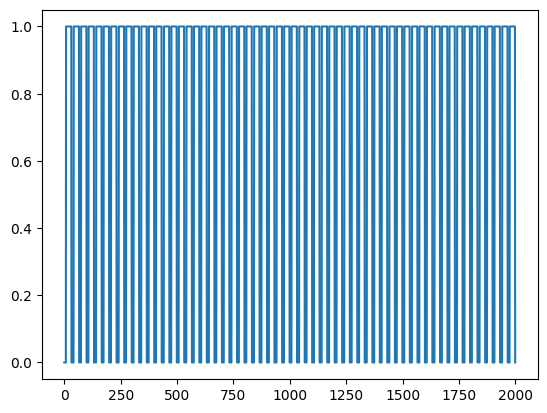

In [ ]:
plt.plot(ttl_test[10000:12000])

TTL Preprocessing Test

In [ ]:
ttl_paths = get_file_paths(directory=data_dir, extension='npy', keyword='ttl')
ttl_data = np.load(ttl_paths[0])

Found 54 ttl.npy files


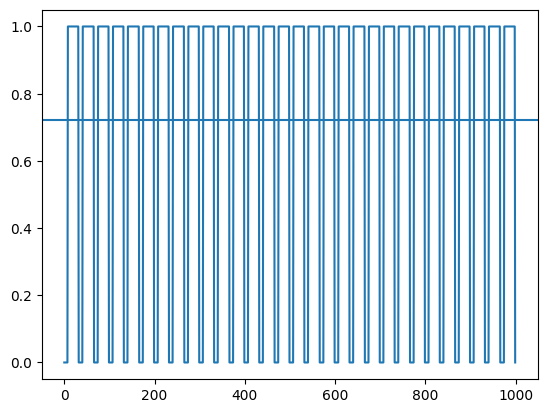

In [ ]:
ttl_mean = np.mean(ttl_data)
plt.plot(ttl_data[50000:51000])
plt.axhline(ttl_mean)

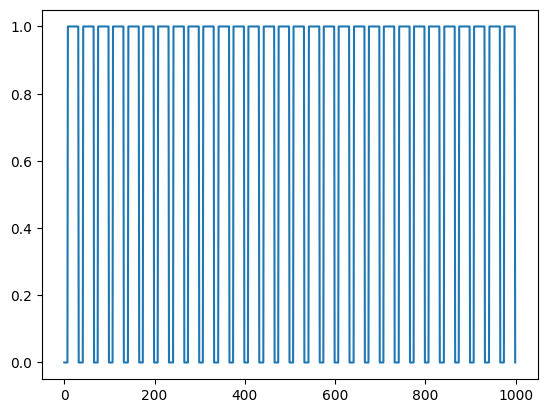

In [ ]:
ttl_bool = ttl_data > 0.0
plt.plot(ttl_bool[10000:11000])

In [ ]:
ttl_bool = ttl_data > float(0)
ttl_transition = -1
ttl_diffs = np.diff(ttl_bool.astype(np.int8))
ttl_frames = np.where(ttl_diffs == ttl_transition)[0]

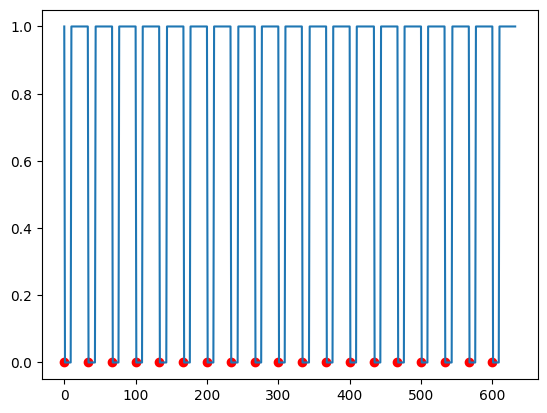

In [ ]:
start = -20
stop = -1
plt.plot(ttl_bool[ttl_frames[start]:ttl_frames[stop]])
plt.scatter(ttl_frames[start:stop]-ttl_frames[start], np.zeros(len(ttl_frames[start:stop])), c='r')

In [ ]:
len(ttl_frames)

81308

In [ ]:
str(video_path[0])

NameError: name 'video_path' is not defined

In [ ]:
import cv2
video_path = get_file_paths(directory = data_dir, extension='avi')
cap = cv2.VideoCapture(str(video_path[0]))

Found 1 .avi files


In [ ]:
cap.get(cv2.CAP_PROP_FRAME_COUNT)

81825.0